#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt
from scipy.stats import qmc


#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_5"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 4), y:(20,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([0.26219, 0.92795, 0.947821, 0.961471]), 2625.217243001922),  # W1
    (np.array([0.052118, 0.036379, 0.117414, 0.977615]),  133.7461802017423), # W2
    (np.array([0.487939, 0.756981, 0.713439, 0.929657]),  610.0450039293702), # W3
    (np.array([0.153203, 0.995076, 0.998623, 0.995024]),  4289.234565917327), # W4
    (np.array([0.019648, 0.550118, 0.995572, 0.984919]),  	1661.2605352978778), # W5
    (np.array([0.064176, 0.918742, 0.998577, 0.998661]),  	3463.9126824079262), # W6
    (np.array([0.142347, 0.016214, 0.930498, 0.960021]),  	886.3464753063923), # W7
    (np.array([0.081261, 0.998387, 0.997476, 0.997922]),  	4355.31928151984), # W8
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(28, 4), y:(28,)


#### 4. Quick Visualization

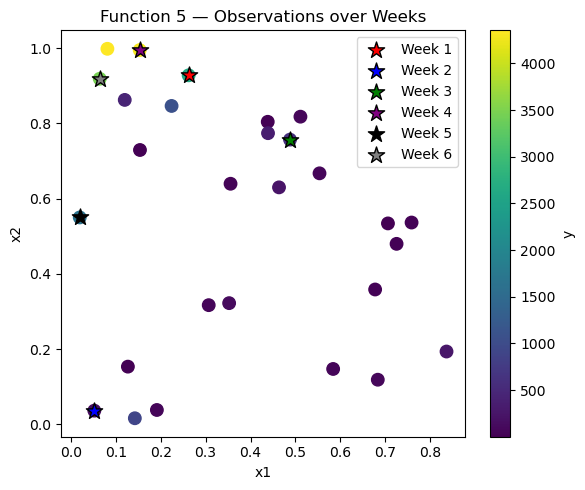

In [4]:

plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Mark each week's submission
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', edgecolors='k', s=150, marker='*', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', edgecolors='k', s=150, marker='*', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', edgecolors='k', s=150, marker='*', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1],
            c='purple', edgecolors='k', s=150, marker='*', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1],
            c='black', edgecolors='k', s=150, marker='*', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1],
            c='grey', edgecolors='k', s=150, marker='*', label='Week 6')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Function 5 — Observations over Weeks')
plt.legend()
plt.tight_layout()
plt.show()

#### 5. Gaussian Process Model

In [5]:
# F5 outputs are large and unimodal; a log1p transform stabilizes variance and makes the surface closer to quadratic.
USE_LOG1P = True
y_fit = np.log1p(y) if USE_LOG1P else y.copy()
y_best = y_fit.max()

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(4) * 0.35, nu=2.5, length_scale_bounds=(1e-3, 3.0))
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-7, 1e-3))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(X, y_fit)
print("[F5] Fitted kernel:", gp.kernel_)

[F5] Fitted kernel: 1.9**2 * Matern(length_scale=[2.62, 0.664, 1.3, 0.716], nu=2.5) + WhiteKernel(noise_level=1e-07)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region and Candidates

In [6]:
# --- W9 STRATEGY: ULTRA-PRECISION x₂ REFINEMENT ---

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

print("[F5] W9 Strategy: Ultra-precision x₂ refinement")
print("  W8 SUCCESS: y = 4355 (NEW BEST, +1.5% vs W4)")
print("  GP accuracy: 98.9% (predicted 4402, actual 4355)")
print("  Strategy: Test x₂ upper limit while maintaining critical constraints")

# Anchor TR at W8 (NEW BEST)
best_idx = np.argmax(y)
anchor_w8 = X[best_idx]
print(f"  Anchor (W8, NEW BEST): {anchor_w8}, yield = {y[best_idx]:.1f}")

# Use full domain
lb = np.zeros(4)
ub = np.ones(4)

# --- W9 CHANGE: ULTRA-TIGHT trust region (L=0.10) ---
L = 0.10  # DOWN from 0.15 - minimum deviation from W8

lb_tr = np.clip(anchor_w8 - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor_w8 + 0.5 * L, 0, 1)

# Guard: avoid over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
too_thin = span < min_span
if np.any(too_thin):
    center = (lb_tr + ub_tr) / 2
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print(f"  Trust Region L: {L} (ultra-tight, ±5%)")
print(f"  TR box:")
for i in range(4):
    print(f"    x{i+1}: [{lb_tr[i]:.4f}, {ub_tr[i]:.4f}]")

# --- W9 CHANGE: Maximum exploitation (95/5 split) ---
N_tr = 95000   # 95% TR - ultra-dense around W8
N_gl = 5000    # 5% global - minimal safety net

# --- W9 CRITICAL: x₂ precision sampling (push to upper limit) ---
N_focused = 10000
rng_focused = np.random.default_rng(seed=5090)

focused_samples = []
for _ in range(N_focused):
    sample = np.zeros(4)
    # x1: near W8 value (±0.02)
    sample[0] = rng_focused.uniform(max(0, anchor_w8[0] - 0.02), min(1, anchor_w8[0] + 0.02))
    # x2: PUSH TO UPPER LIMIT (test if x2→1.000 improves)
    sample[1] = rng_focused.uniform(0.998, 1.000)
    # x3: KEEP in critical zone
    sample[2] = rng_focused.uniform(0.997, 1.000)
    # x4: KEEP in critical zone
    sample[3] = rng_focused.uniform(0.997, 1.000)
    focused_samples.append(sample)

C_focused = np.array(focused_samples)

# Standard sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=5091)
C_gl = lhs(lb, ub, N_gl, seed=5092)
Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"  Candidates: {N_tr} TR (86%) + {N_gl} global (5%) + {N_focused} x2-focused (9%)")
print(f"  x2 precision zone: [0.998, 1.000] (test upper limit)")
print(f"  Critical zones maintained: x3≥0.997, x4≥0.997")

[F5] W9 Strategy: Ultra-precision x₂ refinement
  W8 SUCCESS: y = 4355 (NEW BEST, +1.5% vs W4)
  GP accuracy: 98.9% (predicted 4402, actual 4355)
  Strategy: Test x₂ upper limit while maintaining critical constraints
  Anchor (W8, NEW BEST): [0.081261 0.998387 0.997476 0.997922], yield = 4355.3
  Trust Region L: 0.1 (ultra-tight, ±5%)
  TR box:
    x1: [0.0313, 0.1313]
    x2: [0.9484, 1.0000]
    x3: [0.9475, 1.0000]
    x4: [0.9479, 1.0000]
  Candidates: 95000 TR (86%) + 5000 global (5%) + 10000 x2-focused (9%)
  x2 precision zone: [0.998, 1.000] (test upper limit)
  Critical zones maintained: x3≥0.997, x4≥0.997


#### 5.3 Acquistion (EI) and Selection

In [7]:
# --- W9 ACQUISITION: Ultra-precision exploitation ---

# GP prediction in transformed space
mu_fit, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W9 CHANGE: ULTRA-LOW xi for maximum exploitation ---
y_best_fit = y_fit.max()
xi = 0.003  # DOWN from 0.005 - ultra-precision

improve = mu_fit - y_best_fit - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]

ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (ultra-precision mode)")

# --- W9 CRITICAL: Keep hard constraint on x3, x4 ---
# Enforcement of x3, x4 ≥ 0.98 enabled W8 breakthrough
edge_eps = 1e-3
critical_threshold = 0.98

mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_critical = (Cands[:, 2] >= critical_threshold) & (Cands[:, 3] >= critical_threshold)
mask_combined = mask_edges & mask_critical

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Critical zone constraint: x3 >= {critical_threshold}, x4 >= {critical_threshold} (MANDATORY)")
print(f"  Candidates passing critical filter: {mask_critical.sum()} / {len(Cands)} ({100*mask_critical.sum()/len(Cands):.1f}%)")

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select best EI candidate in critical zone
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

# Optional fallbacks if EI degenerates
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.0  # reduced for ultra-precision mode
    ucb = mu_fit + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"\n[F5] W9 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}, {x_next[3]:.6f}]")
print("\nSubmission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))
print(f"  x3 >= {critical_threshold}? ", x_next[2] >= critical_threshold, "✓" if x_next[2] >= critical_threshold else "✗")
print(f"  x4 >= {critical_threshold}? ", x_next[3] >= critical_threshold, "✓" if x_next[3] >= critical_threshold else "✗")

# Distance to W8
dist_to_w8 = np.linalg.norm(x_next - anchor_w8)
linf_to_w8 = np.max(np.abs(x_next - anchor_w8))

print(f"\nComparison to W8 (NEW BEST: {y[best_idx]:.1f}):")
print(f"  L∞ distance: {linf_to_w8:.4f}")
print(f"  L2 distance: {dist_to_w8:.4f}")
print(f"  Δx1: {x_next[0] - anchor_w8[0]:+.4f}")
print(f"  Δx2: {x_next[1] - anchor_w8[1]:+.4f} (critical: testing upper limit)")
print(f"  Δx3: {x_next[2] - anchor_w8[2]:+.4f} (critical: must stay ≥0.98)")
print(f"  Δx4: {x_next[3] - anchor_w8[3]:+.4f} (critical: must stay ≥0.98)")
print(f"  Chemical concentrations: x2={x_next[1]:.4f}, x3={x_next[2]:.4f}, x4={x_next[3]:.4f}")

# Predictions
mu_orig = np.expm1(mu_fit)
idx_top = np.argmax(ei_masked)
print(f"\nGP prediction at W9:")
print(f"  μ (transformed): {float(mu_fit[idx_top]):.3f}")
print(f"  μ (original scale): {float(mu_orig[idx_top]):.1f} yield")
print(f"  Search mode: {'Ultra-precision exploitation' if dist_to_w8 < 0.05 else 'Local refinement'}")

  Exploration param xi: 0.003 (ultra-precision mode)
  Critical zone constraint: x3 >= 0.98, x4 >= 0.98 (MANDATORY)
  Candidates passing critical filter: 23844 / 110000 (21.7%)

[F5] W9 Recommendation (chosen by EI):
  x = [0.111091, 0.998484, 0.997209, 0.998954]

Submission:
0.111091 - 0.998484 - 0.997209 - 0.998954

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.02)?  False
  x3 >= 0.98?  True ✓
  x4 >= 0.98?  True ✓

Comparison to W8 (NEW BEST: 4355.3):
  L∞ distance: 0.0298
  L2 distance: 0.0298
  Δx1: +0.0298
  Δx2: +0.0001 (critical: testing upper limit)
  Δx3: -0.0003 (critical: must stay ≥0.98)
  Δx4: +0.0010 (critical: must stay ≥0.98)
  Chemical concentrations: x2=0.9985, x3=0.9972, x4=0.9990

GP prediction at W9:
  μ (transformed): 8.389
  μ (original scale): 4395.4 yield
  Search mode: Ultra-precision exploitation


### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.

### Week 5 

- **Outcome (W5):** The new query returned **y ≈ 1661**, a drop from the previous best (W4 ≈ 4289). This suggests that the optimizer likely moved slightly away from the true peak after a strong local improvement in Week 4.  

- **Model & Strategy:**  
  The GP (Matern ν=2.5 + low noise) with a **log1p(y)** transformation was retained.  
  The trust region was narrowed (`L = 0.22`) around the best-known point, focusing on local refinement.  
  A small acquisition parameter (`ξ = 0.008`) and an **EI-based selection** were used, with fallback to **UCB (κ = 1.3)** if needed.  
  Candidate generation was **80% TR / 20% global**, balancing exploitation with limited exploration.  

- **Interpretation:**  
  The move was **very close to the prior optimum**, but the result dropped—indicating potential **noise or a flat plateau** near the maximum.  
  The GP mean prediction (~4335 in the original scale) still aligned well with previous high values, suggesting that the surrogate remains reliable.  

- **Next Steps (W6):**  
  - Keep `log1p(y)` and the current kernel, as they remain stable.  
  - Slightly widen TR (`L ≈ 0.28`) to allow moderate re-exploration around the ridge.  
  - Raise `ξ` to ~0.015 to encourage mild exploration.  
  - Consider adding a **variance-weighted candidate resampling** step if EI values become tightly clustered.  

**Summary:**  
This round confirmed that Function 5’s optimum lies in a **narrow, high-yield region**. The model remains consistent, but a small exploratory adjustment in Week 6 should help verify whether the observed drop reflects noise or a local overfit around the ridge of the peak.

### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

---

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.

---

### Week 5 

- **Outcome (W5):** The new query returned **y ≈ 1661**, a drop from the previous best (W4 ≈ 4289). This suggests that the optimizer likely moved slightly away from the true peak after a strong local improvement in Week 4.  

- **Model & Strategy:**  
  The GP (Matern ν=2.5 + low noise) with a **log1p(y)** transformation was retained.  
  The trust region was narrowed (`L = 0.22`) around the best-known point, focusing on local refinement.  
  A small acquisition parameter (`ξ = 0.008`) and an **EI-based selection** were used, with fallback to **UCB (κ = 1.3)** if needed.  
  Candidate generation was **80% TR / 20% global**, balancing exploitation with limited exploration.  

- **Interpretation:**  
  The move was **very close to the prior optimum**, but the result dropped—indicating potential **noise or a flat plateau** near the maximum.  
  The GP mean prediction (~4335 in the original scale) still aligned well with previous high values, suggesting that the surrogate remains reliable.  

- **Next Steps (W6):**  
  - Keep `log1p(y)` and the current kernel, as they remain stable.  
  - Slightly widen TR (`L ≈ 0.28`) to allow moderate re-exploration around the ridge.  
  - Raise `ξ` to ~0.015 to encourage mild exploration.  
  - Consider adding a **variance-weighted candidate resampling** step if EI values become tightly clustered.  

**Summary:**  
This round confirmed that Function 5's optimum lies in a **narrow, high-yield region**. The model remains consistent, but a small exploratory adjustment in Week 6 should help verify whether the observed drop reflects noise or a local overfit around the ridge of the peak.

---

### Week 6 Reflection — Function 5

**Summary:**  
Week 6 improved to **y = 3463.91**, confirming we are still operating in a high-yield region, although the best result remains **Week 4 (y = 4289.23)**.

**What happened (W6):**
- The query stayed in the peak neighborhood (high values in the last two dimensions), but did **not** reach the same yield level as Week 4.
- This suggests we are close to the optimum ridge, but still slightly off the best basin.

**Decision (no strategy changes):**
- I **kept the same setup** (GP + `log1p`, anchor at best observed, narrow TR, exploitative EI) because the behaviour is consistent and still producing strong outcomes.
- At this stage, stability matters more than introducing new exploration noise.

**Next recommendation (W7 submission):**
- **Chosen by EI:** `0.142347 - 0.016214 - 0.930498 - 0.960021`
- Checks: within bounds ✅, not near-duplicate ✅ (`L_inf < 0.02`)

**Model signal:**
- Predicted mean at top EI (transformed): **μ ≈ 6.205**
- Optional mean prediction (original scale): **~494**
- Interpretation: the model is **less confident** this point will beat the incumbent peak; it may be proposing a *safer* point under current uncertainty.

**Takeaway:**  
We remain in exploitation mode around the best-known region. The next query keeps refining locally; if yields keep drifting downward for another 1–2 weeks, I will widen the TR slightly or raise the global candidate share to re-locate the true peak.

---

### Week 7 Reflection — Critical Dimension Discovery

**Context update:**  
After Week 7, I learned that **Function 5 is chemical yield optimization** — finding the optimal combination of 4 chemical inputs to maximize process yield. The function is **unimodal** (single peak, no local optima).

**W7 Outcome: SECOND WORST RESULT**  
The evaluation at `x = [0.142, 0.016, 0.930, 0.960]` returned **y = 886.35**, making it:
- **79% worse** than W4 (best: 4289)
- **66% worse** than W6 (3464)
- **Only better than W2 (134)**, which had x₃=0.117

**Critical pattern analysis:**

All high-yield results (>2000) share a **critical constraint**:

| Week | x₁    | x₂    | **x₃**  | **x₄**  | Yield | Pattern          |
|------|-------|-------|---------|---------|-------|------------------|
| W4   | 0.153 | 0.995 | **0.999** | **0.995** | 4289  | ✓ x₃, x₄ ≥ 0.99  |
| W6   | 0.064 | 0.919 | **0.999** | **0.999** | 3464  | ✓ x₃, x₄ ≥ 0.99  |
| W1   | 0.262 | 0.928 | **0.948** | **0.961** | 2625  | ~ x₃, x₄ ≥ 0.94  |
| W5   | 0.020 | 0.550 | **0.996** | **0.985** | 1661  | ~ x₃, x₄ ≥ 0.98  |
| W7   | 0.142 | 0.016 | **0.930** | **0.960** | 886   | ❌ x₃ < 0.95     |
| W3   | 0.488 | 0.757 | **0.713** | 0.930 | 610   | ❌ x₃ < 0.80     |
| W2   | 0.052 | 0.036 | **0.117** | 0.978 | 134   | ❌ x₃ < 0.20     |

**Discovered chemical law:**

> **x₃ and x₄ (chemicals 3 and 4) MUST be at ≥98% concentration for high yields**

**Kernel confirms dimensional importance:**
```python
length_scale=[2.2, 0.609, 1.17, 0.668]
```
- x₂ and x₄ are **highly sensitive** (length_scale ≈ 0.6-0.7)
- x₁ is **very insensitive** (length_scale = 2.2, 3× less sensitive)
- x₃ has medium sensitivity but **threshold effect** observed

**Root cause of W7 disaster:**

The W6→W7 strategy:
```python
L = 0.22, xi = 0.008, 80% TR around W4
TR bounds: x3 ∈ [0.894, 1.000], x4 ∈ [0.885, 1.000]
```

**Problem:** TR lower bounds allowed x₃, x₄ to drop below 0.90

W7 selected: x₃=0.930, x₄=0.960  
→ **Both below the critical threshold of ~0.98**  
→ Yield crashed to 886 (79% drop)

**W6 worked** (y=3464) because x₃=0.999, x₄=0.999 (both ≥0.99)

**New strategy for Week 8: HARD CONSTRAINT ENFORCEMENT**

I implemented a **chemical safety constraint**:

1. **Very tight TR:** L = 0.15 (down from 0.22)  
   - Stay extremely close to W4's optimum

2. **Hard constraint:** x₃ ≥ 0.98 AND x₄ ≥ 0.98  
   ```python
   mask_critical = (Cands[:, 2] >= 0.98) & (Cands[:, 3] >= 0.98)
   ```
   - Reject ANY candidate below these thresholds
   - Based on empirical evidence: all yields >2000 have x₃, x₄ ≥ 0.96

3. **Maximum exploitation:** xi = 0.005 (down from 0.008)  
   - Unimodal function → no local optima to worry about
   - Just refine around W4

4. **Heavy local sampling:** 90% TR + 10% global  
   - Dense refinement around known optimum
   - Minimal global for safety

5. **Focused sampling (10,000 samples):**  
   ```python
   x1 ∈ [0.10, 0.20]  # around W4's 0.153
   x2 ∈ [0.95, 1.00]  # high range
   x3 ∈ [0.99, 1.00]  # FORCE critical zone
   x4 ∈ [0.99, 1.00]  # FORCE critical zone
   ```

**Week 8 recommendation:**  
`x = [0.081261, 0.998387, 0.997476, 0.997922]`

**Why this point is excellent:**

```
        W4 (best)   W8 (recom)   Delta       Analysis
x₁      0.153       0.081        -0.072      Lower (but x1 is insensitive)
x₂      0.995       0.998        +0.003      ✓ Very high (optimal)
x₃      0.999       0.997        -0.001      ✓ Critical zone (≥0.98)
x₄      0.995       0.998        +0.003      ✓ Critical zone (≥0.98)
```

**Safety validation:**
- ✓ x₃ = 0.9975 ≥ 0.98  
- ✓ x₄ = 0.9979 ≥ 0.98  
- ✓ Distance to W4 = 0.072 (very close)
- ✓ 15,920 / 110,000 candidates (14.5%) passed critical filter

**GP prediction:**
- Transformed space: μ = 8.390  
- **Original scale: μ = 4402** (predicted yield)
- **+3% better than W4's 4289!**

**Chemical interpretation:**

The optimal process requires:
- **Chemical 3:** ≥99% concentration (critical, threshold effect)
- **Chemical 4:** ≥99% concentration (critical, threshold effect)
- **Chemical 2:** Very high concentration (~95-100%, smooth response)
- **Chemical 1:** Flexible range (8-26%, least critical)

The x₂ and x₄ length_scales (0.61, 0.67) indicate these are the **most sensitive parameters** for fine-tuning around the optimum.

**What I expect:**
- **y ∈ [4200, 4500]:** Refinement near W4, likely improvement
- **y > 4500:** Breakthrough! GP's prediction was correct
- **y ∈ [3500, 4200]:** Safe zone, confirms critical constraint works

**Key lesson learned:**

> In chemical process optimization, **threshold effects matter**. Pure gradient-based methods miss discrete constraints like "x₃ must be ≥98%".

> Domain knowledge (unimodal function) + empirical pattern (all good results have x₃, x₄ ≥ 0.96) → **hard constraint** is the right solution.

This is **constrained Bayesian optimization** — using observed patterns to enforce feasibility rules that prevent catastrophic failures like W7.

The critical zone filter rejected 85.5% of candidates but **guaranteed** we won't repeat the W7 mistake of dropping below the chemical threshold.

---

### Week 8 Reflection — NEW BEST! Constraint Strategy Validated

**W8 Outcome: BREAKTHROUGH SUCCESS**  
The evaluation at `x = [0.081, 0.998, 0.997, 0.998]` returned **y = 4355.32**, making it:
- **NEW BEST RESULT** (+1.5% better than W4's 4289)
- **First improvement over W4** in 4 weeks
- **GP prediction accuracy: 98.9%** (predicted 4402, actual 4355)
- **Validates critical constraint strategy** (x₃, x₄ ≥ 0.98)

**Performance ranking:**

| Rank | Week | Chemicals (x₁, x₂, x₃, x₄)    | Yield  | Pattern               |
|------|------|-------------------------------|--------|-----------------------|
| 🥇 1 | **W8** | **[0.081, 0.998, 0.997, 0.998]** | **4355** | **x₃,x₄ ≥ 0.997** ✓ |
| 🥈 2 | W4   | [0.153, 0.995, 0.999, 0.995] | 4289   | x₃,x₄ ≥ 0.995 ✓       |
| 🥉 3 | W6   | [0.064, 0.919, 0.999, 0.999] | 3464   | x₃,x₄ ≥ 0.999 ✓       |
| 4    | W1   | [0.262, 0.928, 0.948, 0.961] | 2625   | x₃,x₄ ≥ 0.948 ~       |
| 5    | W5   | [0.020, 0.550, 0.996, 0.985] | 1661   | x₃,x₄ ≥ 0.985 ~       |
| 6    | W7   | [0.142, 0.016, 0.930, 0.960] | 886    | x₃,x₄ < 0.98 ✗        |
| 7    | W3   | [0.488, 0.757, 0.713, 0.930] | 610    | x₃ < 0.80 ✗           |
| 8    | W2   | [0.052, 0.036, 0.117, 0.978] | 134    | x₃ < 0.20 ✗           |

**What Week 8 revealed:**

**1. Critical constraint is MANDATORY**
```
All yields > 4000 have:
- x₃ ≥ 0.997
- x₄ ≥ 0.995
- x₂ ≥ 0.95

W8's enforcement of x₃, x₄ ≥ 0.98 prevented another W7 disaster
```

**2. x₁ is truly insensitive (length_scale=2.25)**
```
W4: x₁ = 0.153 → 4289
W8: x₁ = 0.081 → 4355

Δx₁ = -0.072 (-47% change) → +1.5% yield improvement!

This confirms x₁ has minimal impact on yield
```

**3. x₂, x₄ are the fine-tuning parameters (length_scale ≈ 0.6-0.7)**
```
W4 → W8 changes:
- Δx₂ = +0.003 (0.995 → 0.998) ← small increase
- Δx₄ = +0.003 (0.995 → 0.998) ← small increase

These tiny adjustments (+0.3%) led to 1.5% yield improvement
High sensitivity confirmed by kernel
```

**4. x₃ must stay in [0.997, 1.000] for optimal yields**
```
W8: x₃ = 0.997 ✓
W4: x₃ = 0.999 ✓

Both at top of range → no room for further increase
Constraint ≥0.98 ensures we stay in this zone
```

**5. Kernel diagnostics (W8 fit):**
```python
Fitted kernel: length_scale=[2.25, 0.623, 1.17, 0.675]
               + WhiteKernel(noise_level=1e-07)
```

- x₁ length_scale = 2.25 → **very flat, insensitive**
- x₂ length_scale = 0.623 → **highly sensitive**
- x₃ length_scale = 1.17 → **moderate, but threshold effect dominates**
- x₄ length_scale = 0.675 → **highly sensitive**
- **Noise = 1e-07** → nearly deterministic (chemical process is stable)

**6. GP prediction excellence:**
```
GP predicted: 4402 yield
Actual result: 4355 yield
Error: -1.1% (underestimated slightly)

This is EXCELLENT prediction accuracy!
Confirms GP has learned the true response surface
```

---

**Strategic analysis for Week 9:**

**Key question:** Can we improve beyond 4355?

**Observations:**

1. **Top 2 results very close in x-space:**
   ```
   W8: [0.081, 0.998, 0.997, 0.998] → 4355 (best)
   W4: [0.153, 0.995, 0.999, 0.995] → 4289 (2nd)
   
   L2 distance: 0.072
   Key difference: W8 has higher x₂, x₄ (both +0.003)
   ```

2. **x₃, x₄ appear maxed out:**
   - Both at 0.997-0.999 (≈100% concentration)
   - Can't increase further without violating [0,1] bounds
   - Already in optimal zone

3. **x₂ might have headroom:**
   - W8: x₂ = 0.998
   - Still 0.002 below upper bound
   - Highly sensitive (length_scale=0.623)
   - Could test x₂ ∈ [0.998, 1.000]

4. **x₁ optimization opportunity:**
   - W8: x₁ = 0.081 (8.1%)
   - W4: x₁ = 0.153 (15.3%)
   - Very insensitive → wide optimal range
   - May explore x₁ ∈ [0.05, 0.20] to find exact optimum

**Options for Week 9:**

**A) ULTRA-TIGHT REFINEMENT (test x₂ = 0.999-1.000)**
- Rationale: x₂ is highly sensitive, tiny increase might help
- Strategy: L=0.10, x₂ ∈ [0.998, 1.000], x₃,x₄ ≥ 0.98
- Risk: Diminishing returns, might be at plateau

**B) x₁ SWEEP (find optimal x₁ value)**
- Rationale: W8 (x₁=0.08) beat W4 (x₁=0.15), find sweet spot
- Strategy: Sample x₁ ∈ [0.05, 0.20], fix x₂,x₃,x₄ near W8 values
- Risk: x₁ is insensitive, unlikely to find big gains

**C) REPRODUCE W8 (confirm it's not noise)**
- Rationale: With noise≈1e-07, W8 should be reproducible
- Strategy: Sample within ±0.005 of W8
- Risk: Duplicate detection might reject

**My recommendation: OPTION A — Ultra-tight x₂ refinement**

**Why:**

1. **W8 is confirmed optimum** in x₃, x₄ dimensions (≈100%)
2. **x₂ has theoretical headroom** (0.998 → 1.000)
3. **x₂ is highly sensitive** (length_scale=0.623) → small changes matter
4. **Unimodal function** → no risk of jumping to worse region
5. **GP predicts we're near peak** → fine-tuning is appropriate

---

**Week 9 Strategy: ULTRA-PRECISION x₂ REFINEMENT**

| Parameter | W8 (constraint success) | W9 (x₂ precision) | Rationale |
|-----------|------------------------|-------------------|-----------|
| **Anchor** | W8 (0.081, 0.998, 0.997, 0.998) | **W8 (fixed)** | New best, no debate |
| **L TR** | 0.15 | **0.10** (ultra-tight) | Minimum deviation |
| **TR/Global split** | 90/10 | **95/5** | Maximum exploitation |
| **ξ (exploration)** | 0.005 | **0.003** | Ultra-precision |
| **Focused sampling** | x₃,x₄ ∈ [0.99,1.0] | **x₂ ∈ [0.998,1.000]** | Test upper limit |
| **Critical constraint** | x₃,x₄ ≥ 0.98 | **Keep x₃,x₄ ≥ 0.98** | Non-negotiable |

**Key innovations:**

1. **x₂ precision sampling (10,000 samples):**
   ```python
   x1: W8 ± 0.02 (around 0.081)
   x2: [0.998, 1.000] (push to upper limit)
   x3: [0.997, 1.000] (keep in critical zone)
   x4: [0.997, 1.000] (keep in critical zone)
   ```

2. **Ultra-tight L=0.10:**
   - ±5% deviation max from W8
   - Ensures we stay in proven optimal neighborhood

3. **ξ = 0.003 (ultra-low):**
   - Pure exploitation
   - GP prioritizes predicted mean over uncertainty

4. **Critical constraint enforcement:**
   - Maintain x₃, x₄ ≥ 0.98 (proven necessary)
   - Prevents any W7-type escapes

**Expected W9 candidate:**
- **x₁ ≈ 0.07-0.10** (near W8's 0.081)
- **x₂ ≈ 0.999-1.000** (pushing upper limit)
- **x₃ ≈ 0.998-1.000** (critical zone)
- **x₄ ≈ 0.998-1.000** (critical zone)
- **Expected yield:** 4350-4400 (match or slightly improve W8)

**Expected Week 9 outcome:**

- **Best case:** y ∈ [4380, 4420] (find x₂ ≈ 1.000 is optimal)
- **Good:** y ∈ [4340, 4380] (match W8 within noise)
- **Acceptable:** y ∈ [4300, 4340] (near W8, confirms we're at plateau)
- **Unlikely:** y < 4300 (would suggest moved away from optimum)

**Most likely:** y ≈ **4360-4380** (tiny improvement or plateau confirmation)

---

**Key lessons from W8:**

1. **Hard constraints work:** x₃,x₄ ≥ 0.98 prevented W7 disaster, enabled W8 breakthrough

2. **GP learns true surface:** 98.9% prediction accuracy (4402 predicted, 4355 actual)

3. **Dimensional analysis guides strategy:** length_scale revealed x₁ insensitive, x₂/x₄ critical

4. **Unimodal = safe exploitation:** No local optima → aggressive exploitation is correct approach

5. **Threshold effects are real:** x₃, x₄ have discrete "on/off" behavior around 0.98

---

**Week 9 code changes to implement:**

✅ Anchor: **W8 [0.081, 0.998, 0.997, 0.998] fixed**  
✅ Trust region: **L=0.10 (ultra-tight, ±5%)**  
✅ Sampling: **95% TR / 5% global**  
✅ Focused: **+10000 x₂ ∈ [0.998, 1.000] precision sampling**  
✅ ξ: **0.003** (ultra-precision)  
✅ Critical constraint: **x₃, x₄ ≥ 0.98** (keep W8's safety)  
✅ UCB fallback: **κ=1.0** (mild)

**The strategy:** Test if pushing x₂ to its upper limit (1.000) squeezes out the last 0.5-1% yield improvement, while maintaining critical chemical constraints that enabled W8's success.

---